# CircRL Demo Notebook

This notebook demonstrates how to use CircRL to run rollouts, cache
activations, train linear probes on cached activations, and apply
arbitrary hook functions during a rollout.

Dependencies required for this demo can be installed with
`pip install -r requirements_demo.txt`.

Start with various required imports, and some boilerplate to download
and open a pre-trained Pong-playing agent, and set up a Pong environment...

In [8]:
# Imports
import warnings
import numpy as np
import pandas as pd
import torch as t
from einops import rearrange
from IPython.display import display, Video, Image
from moviepy.editor import VideoFileClip

from huggingface_hub import hf_hub_download

from stable_baselines3.common.env_util import make_atari_env
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.policies import ActorCriticCnnPolicy
from stable_baselines3 import PPO

import plotly.express as px

import circrl.hooks as chk
import circrl.rollouts as cro
import circrl.probing as cpr

# Boilerplate to make sure we can reload modules
try:
    # pylint: disable=import-outside-toplevel
    from IPython import get_ipython  # type: ignore

    # pylint: enable=import-outside-toplevel

    get_ipython().run_line_magic("reload_ext", "autoreload")  # type: ignore
    get_ipython().run_line_magic("autoreload", "2")  # type: ignore
except AttributeError:
    pass

# Suppress some necessary warnings for cleaner output
# (E.g. messages about version differences with the saved policy used in
# this demo)
warnings.filterwarnings(
    "ignore",
    message="You are probably loading a model saved with SB3",
    category=UserWarning,
)
warnings.filterwarnings(
    "ignore",
    message="WARN: No render fps was declared in the environment",
    category=UserWarning,
)
warnings.filterwarnings(
    "ignore",
    message="Precision and F-score are ill-defined",
)

# Define an environment setup function
def env_setup(seed):
    env = make_atari_env(
        "PongNoFrameskip-v4",
        n_envs=1,
        seed=seed,
        # wrapper_kwargs={"action_repeat_probability": 0.25},
    )
    env = VecFrameStack(env, n_stack=4)
    return env, {"seed": seed}


# Download model, and load it for prediction
model_path = hf_hub_download(
    repo_id="sb3/ppo-PongNoFrameskip-v4", filename="ppo-PongNoFrameskip-v4.zip"
)
env = env_setup(0)[0]
dummy_ppo = PPO(ActorCriticCnnPolicy, env, 0.0)
# Custom object overrides are required for sb3 cross-version compatibility
custom_objects = {
    "learning_rate": 0.0,
    "lr_schedule": lambda _: 0.0,
    "clip_range": lambda _: 0.0,
    "observation_space": dummy_ppo.observation_space,
    "action_space": dummy_ppo.action_space,
}
model = PPO.load(model_path, custom_objects=custom_objects)

Then we can use CircRL to run a bunch of rollouts and save the data to a new timestamped folder:

In [2]:
# Run many rollouts using CircRL
cro.make_dataset(
    model.predict,
    "Testing",
    "datasets",
    10,
    env_setup,
    initial_seed=0,
    run_rollout_kwargs=dict(show_pbar=False),
)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/monte/anaconda3/envs/circrl-dev/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


We can also run a single rollout, but cache certain hidden-layer
activations at each step during the rollout for use later.
Specifically, in this case we cache the output of the first
convolutional layer, and the action logits, which will use for a simple
linear probing demo later:

In [3]:
# Run a rollout while caching
ACTIVS_LAYER = "features_extractor.cnn.1"
LOGITS_LAYER = "action_net"
activs_list = []
logits_list = []


def cache_predict(*args, **kwargs):
    """Custom predict func that caches activations from an intermediate
    convolutional layer."""
    with chk.HookManager(
        model.policy, cache=[ACTIVS_LAYER, LOGITS_LAYER]
    ) as cache_result:
        action = model.predict(*args, **kwargs)
        activs_list.append(cache_result[ACTIVS_LAYER])
        logits_list.append(cache_result[LOGITS_LAYER])
    return action


# Run a single episode using CircRL, using the custom predict function
# that caches activations from an intermediate convolutional layer.
# Create a new environment to ensure deterministic results
env = env_setup(0)[0]
seq, episode_return, step_cnt = cro.run_rollout(
    cache_predict,
    env,
    max_episodes=1,
)

# Concatenate the cached activations so that batch dimension contains
# all the chached timesteps
activs = t.cat(activs_list, dim=0)
logits = t.cat(logits_list, dim=0)
print(activs.shape)

0it [00:00, ?it/s]

torch.Size([1652, 32, 20, 20])


We can use these cached activations for a simple probing demo: 
1. We'll set up a boolearn probe target based on the action logits,
   which will be True if the probability of the agent moving the paddle
   up is very high (>90%), False otherwise.
2. We'll train a sparse linear probe to predict this "high probability
   of paddle-up" target using activations from the first convolutional
   layer output -- in other words, try to find a linear combination of a
   small number of activations that accurately predict the final action
   probability.

Spoiler alert: due to the simplicity and predictability of the default
Pong environment, this sparse probe works surprisingly well even using
only a very small fraction of activations.

(Note that this isn't intended to represent a sensible mech interp
research question -- just a simple and accessible example to demonstrate
the probing functionality.  A more useful probe target might be "pixel
contains the ball", or whatever.)

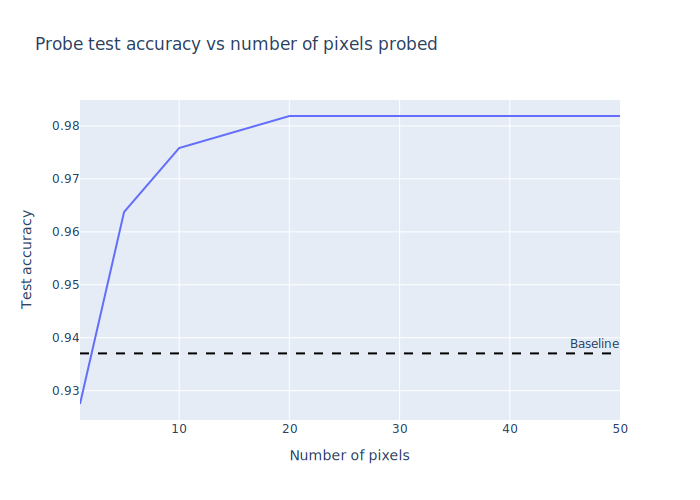

In [4]:
# Demonstrate probing by finding conv pixels that seem to predict a high
# probability of moving the paddle up

# Get action meanings from the environment
action_strs = env.envs[0].unwrapped.get_action_meanings()

# Get the action indices that correspond to moving the paddle up, which
# are RIGHT and RIGHTFIRE
up_action_idxs = [action_strs.index("RIGHT"), action_strs.index("RIGHTFIRE")]

# Convert the previously cached logits to probabilities
probs = t.nn.functional.softmax(logits, dim=-1)

# Calculate the sum of the probabilities of moving the paddle up
up_probs = probs[:, up_action_idxs].sum(dim=-1)

# Our probe objective variable is the a thresholded version
is_strong_up = (up_probs > 0.9).cpu().numpy()

# Now use CircRL to probe!
# We use a sparse probe to see if we can find a small set of conv pixels
# that predict strong paddle-up actions
SPARSE_NUMS = [1, 5, 10, 20, 50]
probe_results = []
for sparse_num in SPARSE_NUMS:
    result = cpr.linear_probe(
        activs.cpu().numpy(),
        is_strong_up,
        sparse_method="f_test",
        sparse_num=sparse_num,
        random_state=0,
        C=1,
    )
    probe_results.append(
        {"sparse_num": sparse_num, "test_score": result["test_score"]}
    )
probe_results = pd.DataFrame(probe_results)

baseline = is_strong_up.mean()
baseline = max(baseline, 1 - baseline)

fig = px.line(
    probe_results,
    x="sparse_num",
    y="test_score",
    title="Probe test accuracy vs number of pixels probed",
    labels={"test_score": "Test accuracy", "sparse_num": "Number of pixels"},
    render_mode="svg",
)

# Add a labelled horizontal line for the baseline accuracy
fig.add_hline(
    y=baseline,
    line_dash="dash",
    line_color="black",
    annotation_text="Baseline",
)

fig.show("svg")

Finally, we demonstrate the use of an arbitrary hook
function to mean-ablate the 1% of activations in the same layer that are
most predictive of the "high probability of paddle-up" target according
to the f-test metric used in the sparse probing code by default.  We
expect that this will cause the policy to miss important "paddle-up"
actions and thus get worse performance (spoiler alert: it does).

0it [00:00, ?it/s]


WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.




MoviePy - Building file temp.gif with imageio.


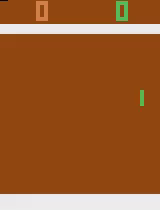

In [10]:
# Demonstrate custom hook functions mean-ablating the 1% of pixels that
# are most predictive of moving the paddle up
FRAC = 0.01

activs_flat = rearrange(activs, "b ... -> b (...)")
f_test, _ = cpr.f_classif_fixed(activs_flat.cpu().numpy(), is_strong_up)
top_inds = t.tensor(
    np.argsort(f_test)[::-1][: int(FRAC * f_test.shape[0])].copy()
).to(activs.device)

mean_activs_flat = activs_flat.mean(axis=0)


def hook_func(input, output):
    """Custom hook function to mean-ablate certain pixels from a conv
    layer."""
    # pylint: disable=unused-argument
    # Flatten the output, patch the specific indices with the mean
    # value, then return to the original shape
    output_flat = rearrange(output, "b c h w -> b (c h w)")
    output_flat[:, top_inds] = mean_activs_flat[top_inds]
    output = rearrange(
        output_flat,
        "b (c h w) -> b c h w",
        c=output.shape[1],
        h=output.shape[2],
    )
    return output


env = env_setup(0)[0]
with chk.HookManager(model.policy, hook={ACTIVS_LAYER: hook_func}) as _:
    # Run a single episode using CircRL
    seq, episode_return, step_cnt = cro.run_rollout(
        model.predict,
        env,
        max_episodes=1,
    )

# Make video
vid_fn, fps = cro.make_video_from_renders(seq.renders, fps=30.0)

# Display video (won't show in Github static view)
# display(Video(vid_fn, embed=True, width=300))

# Display GIF of first part of video
clip = VideoFileClip(vid_fn).subclip(0, 10)
clip.write_gif("temp.gif", fps=10)
display(Image("temp.gif", width=300))